step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

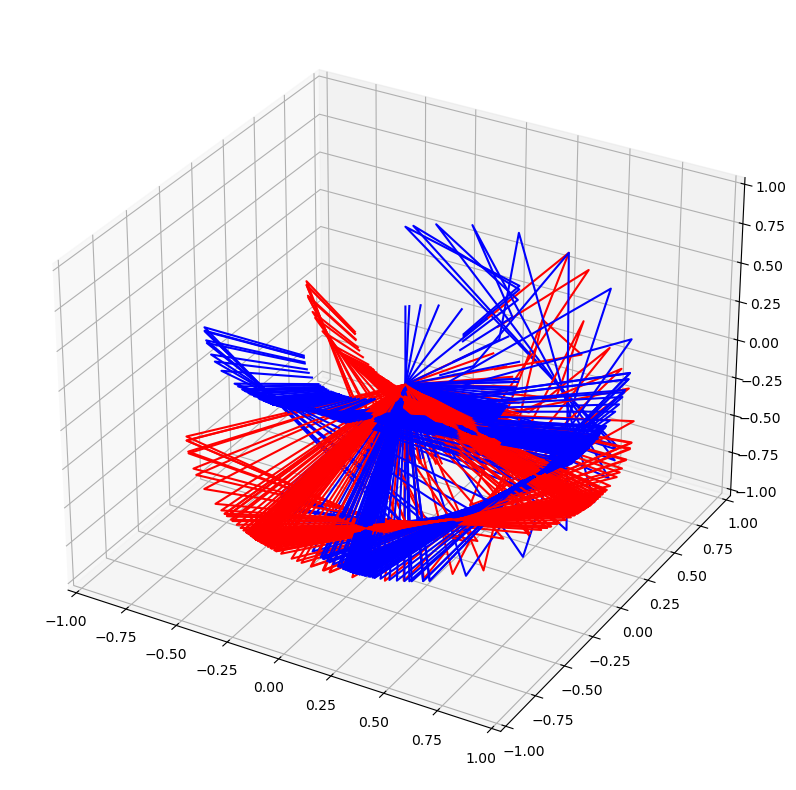

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def quatanion(w,l,m,n):
    lam = np.array([l,m,n])
    norm = np.linalg.norm(lam)
    lam = lam/norm
    
    quatanion = np.append(np.cos(w/2),lam*np.sin(w/2))
    return quatanion[:,np.newaxis]

def cross(q,p)    :
    
    D = np.array([[q[0][0],-q[1][0],-q[2][0],-q[3][0]],
                  [q[1][0],q[0][0],-q[3][0],q[2][0]],
                  [q[2][0],q[3][0],q[0][0],-q[1][0]],
                  [q[3][0],-q[2][0],q[1][0],q[0][0] ]   ])
    
    
    #print(D.shape)
    #print(D)
    return np.dot(D,p)

def bar(q):
    hoge = np.array([q[0][0],-q[1][0],-q[2][0],-q[3][0]])

    return hoge[:,np.newaxis]    

def COA_matrix(q):
    q0 = q[0][0]
    q1 = q[1][0]
    q2 = q[2][0]
    q3 = q[3][0]
    hoge = np.array([[q0**2+q1**2-q2**2-q3**2,2*(q1*q2-q3*q0),2*(q3*q1+q2*q0)],
                     [2*(q1*q2+q3*q0),q2**2-q3**2-q1**2+q0**2,2*(q2*q3-q1*q0)],
                     [2*(q3*q1-q2*q0),2*(q2*q3+q1*q0),q3**2-q1**2-q2**2+q0**2]])
    return hoge

def Childe(r):
    r1 = r[0][0]
    r2 = r[1][0]
    r3 = r[2][0]
    
    hoge = np.array([[0,-r3,r2],
                     [r3,0,-r1],
                     [-r2,r1,0]])
    
    return hoge

def normalize(v, axis=-1, order=2):
    l2 = np.linalg.norm(v, ord = order, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return v/l2

"""
時間
"""
step = 0
T = 4000
dt = 0.01

step_system = 10  #実システムの方は細かく動かす
dt_system  = dt/step_system


"""
初期値
"""
w_pre  = np.asarray([0,0,0])
w_pre = w_pre[:,np.newaxis]   

w_true = np.asarray([0,0,0])
w_true = w_true[:,np.newaxis]   

q_pre  = quatanion(90/180*np.pi,1,1,0)
q_true = quatanion(0,1,0,0)

P_0 = np.diag([0.1,0.1,0.1  ,0.1,0.1,0.1,0.1])

gif_name = 'V10_W.gif'

"""
推定値:この値は使わない。ただの宣言：必要ないが
"""
w_pre_next = np.asarray([0,0,0])
w_pre_next = w_pre_next[:,np.newaxis]
q_pre_next = quatanion(0,1,0,0)

"""
パラメータ
"""
I= np.array([[1,0,0],
             [0,1,0],
             [0,0,1]])
inv_I = np.linalg.inv(I)

C= np.array([[1.1,0,0],
             [0,1.1,0],
             [0,0,1.1]])
IC = np.dot(inv_I,C)

r_AP =  np.asarray([-1,-1,-1])
r_AP = r_AP[:,np.newaxis]   

Ir_AP = np.dot(inv_I,Childe(r_AP))

m = 0.5
g = 9.81
F_OA = np.asarray([0,0,-m*g])
F_OA = F_OA[:,np.newaxis]

N_A = np.asarray([0,0,0])
N_A = N_A[:,np.newaxis]

mgIr_AP = m*g*Ir_AP

C = np.eye(3)
hoge = np.zeros((3,4))
C = np.concatenate([C,hoge],1)
    
"""
カルマンフィルタ　EKF用パラメータ
"""
W = np.diag([0.1,0.1,0.1  ,0.1,0.1,0.1,0.1])
V = np.diag([0.1,0.1,0.1])*10

"""
グラフ用変数
"""
q_history = q_true
q_pre_history = q_pre

while True:
    print("step",step)
    """
    実システムの方の挙動
    """
    
    for i in range(step_system):
        d_w_true  = - np.dot(IC,w_true) - np.dot(inv_I,N_A) \
                            - np.dot(np.dot(Ir_AP,COA_matrix(q_true).T),F_OA)  #運動方程式
        w_true = w_true + d_w_true * dt_system
        
        wv = np.asarray([0,w_true[0][0],w_true[1][0],w_true[2][0]])
        wv = wv[:,np.newaxis]
        d_q_true = 0.5 *cross(q_true,wv)
        q_true = q_true + d_q_true * dt_system
        
        q_true = normalize(q_true,axis = 0)
        
    y = w_true    #計測によって、角速度が得られる。           
    
    """
    微分して、線形化する
    """
    qw = q_pre[0][0]
    qx = q_pre[1][0]
    qy = q_pre[2][0]
    qz = q_pre[3][0]
    
    wx = w_pre[0][0]
    wy = w_pre[1][0]
    wz = w_pre[2][0]
    
    
    
    A_w = np.array([[-2*qy,2*qz,-2*qw,2*qx],
                    [2*qx,2*qw,2*qz,2*qy],
                    [2*qw,-2*qx,-2*qy,2*qz]])
    
    
    hoge = np.dot(mgIr_AP ,  A_w)
    AC_w = np.concatenate([-IC,hoge],1)
    
    A_q =0.5* np.array([[-qx,-qy,-qz,0,-wx,-wy,-wz],
                    [qw,-qz,qy,wx,0,wz,-wy],
                    [qz,qw,-qx,wy,-wz,0,wx],
                    [-qy,qx,qw,wz,wy,-wx,0]])
    
    
    A = np.concatenate([AC_w,A_q],0)
    
    
    
    hoge2 = np.array([[2*(qz*qx - qy*qw)],
                      [2*(qy*qz+qx*qw)],
                      [qw**2-qx**2-qy**2+qz**2]])
    hoge = np.dot(mgIr_AP, hoge2 - np.dot(A_w,q_pre))
    
    hoge3=0.5*np.array([[-qx*wx-qy*wy-qz*wz],
                        [qw*wx-qz*wy+qy*wz],
                        [qz*wx+qw*wy-qx*wz],
                        [-qy*wx+qx*wy+qx*wz]])
    
    hoge3 = hoge3 - np.dot(A_q,np.concatenate([w_pre,q_pre],0))
    
                           
    
    bk= np.concatenate([hoge,hoge3],0)
    
    """
    離散化
    
    dot x = Ax + bk + v
    y = Cx + w
    
    を
    
    x_k+1 = (Adt + eye)x_k + bkdt +v
    y = Cx + w
    
    にする
    """
    
    A_d = A*dt + np.eye(7)
    bkdt = bk*dt
        
    
    """
    EKFを用いた推定部分
    """
    x_pre = np.concatenate([w_pre,q_pre],0)
    x_next = np.dot(A_d,x_pre)+bkdt
    
    P_next = np.dot(np.dot(A_d,P_0),A_d.T)+W
    
    #予測値の補正
    S = np.dot(np.dot(C,P_next),C.T) + V
    K = np.dot(np.dot(P_next,C.T),np.linalg.inv(S))
    P_hosei = np.dot((np.eye(7) - np.dot(K,C)),P_next)
    x_hosei = x_next + np.dot(K,y - np.dot(C,x_next))
    
    """
    更新部
    """
    P_0 = P_hosei
    w_pre = x_hosei[0:3]
    q_pre = x_hosei[3:8]
    
    norm = np.linalg.norm(q_pre)
    q_pre = q_pre / norm
    
    
    """
    グラフ用に保存
    """
    q_history = np.append(q_history,q_true,axis = 1)
    q_pre_history = np.append(q_pre_history,q_pre,axis = 1)
    
    step = step + 1
    
    if step>=T:
        break
    

"""
グラフ化
"""
    


"""
3次元で gif化する
"""
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# x, y, z成分のデータの作成

# x =  np.array([0,1,0,0,0,0,0,1])
# y =  np.array([0,0,0,1,0,0,1,0])
# z =  np.array([0,0,1,0,0,1,0,0])

# x =  np.array([0,1,0,0,0,0])
# y =  np.array([0,0,0,1,0,0])
# z =  np.array([0,0,1,0,0,1])

x =  np.array([0  ,0  ,1  ,0  ,0  ,0])
y =  np.array([0  ,0  ,0  ,0  ,1  ,0.5])
z =  np.array([0.5,0  ,0  ,1  ,0  ,0])

#ax.plot(x, y, z, color='blue')
#ax.scatter(x, y, z, color='blue')

min_range = -1
max_range = 1
ax.set_xlim(min_range, max_range)
ax.set_ylim(min_range, max_range)
ax.set_zlim(min_range, max_range)

ims = []

for i in range(300):

    """
    save_qに従い，座標変換行列CAOを作り，らせんの点を移動しながら，プロットする
    """
    COA = COA_matrix(q_history.T[i*10].reshape(4,1))
    rotate_x = []
    rotate_y = []
    rotate_z = []
    for j in range(6):
        vec_xyz = np.array([x[j],y[j],z[j]])
        vec_xyz =vec_xyz.reshape([3,1])
        vec_xyz = np.dot(COA,vec_xyz)
        rotate_x = np.append(rotate_x,vec_xyz[0][0])
        rotate_y = np.append(rotate_y,vec_xyz[1][0])
        rotate_z = np.append(rotate_z,vec_xyz[2][0])

    im1, = ax.plot(rotate_x, rotate_y, rotate_z, color='blue')
    
    COA = COA_matrix(q_pre_history.T[i*10].reshape(4,1))
    rotate_x2 = []
    rotate_y2 = []
    rotate_z2 = []
    for j in range(6):
        vec_xyz = np.array([x[j],y[j],z[j]])
        vec_xyz =vec_xyz.reshape([3,1])
        vec_xyz = np.dot(COA,vec_xyz)
        rotate_x2 = np.append(rotate_x2,vec_xyz[0][0])
        rotate_y2 = np.append(rotate_y2,vec_xyz[1][0])
        rotate_z2 = np.append(rotate_z2,vec_xyz[2][0])

    im2, = ax.plot(rotate_x2, rotate_y2, rotate_z2, color='red')
    
    ims.append([im1,im2])


ani = animation.ArtistAnimation(fig, ims, interval=100)
plt.show()

ani.save(gif_name, writer='pillow')

